# Missing Data Imputation using Regression

## Determining missing values 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

In [3]:
df = pd.read_csv("../input/diabetes.csv")
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.loc[df["Glucose"] == 0.0, "Glucose"] = np.NAN
df.loc[df["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
df.loc[df["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
df.loc[df["Insulin"] == 0.0, "Insulin"] = np.NAN
df.loc[df["BMI"] == 0.0, "BMI"] = np.NAN

df.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

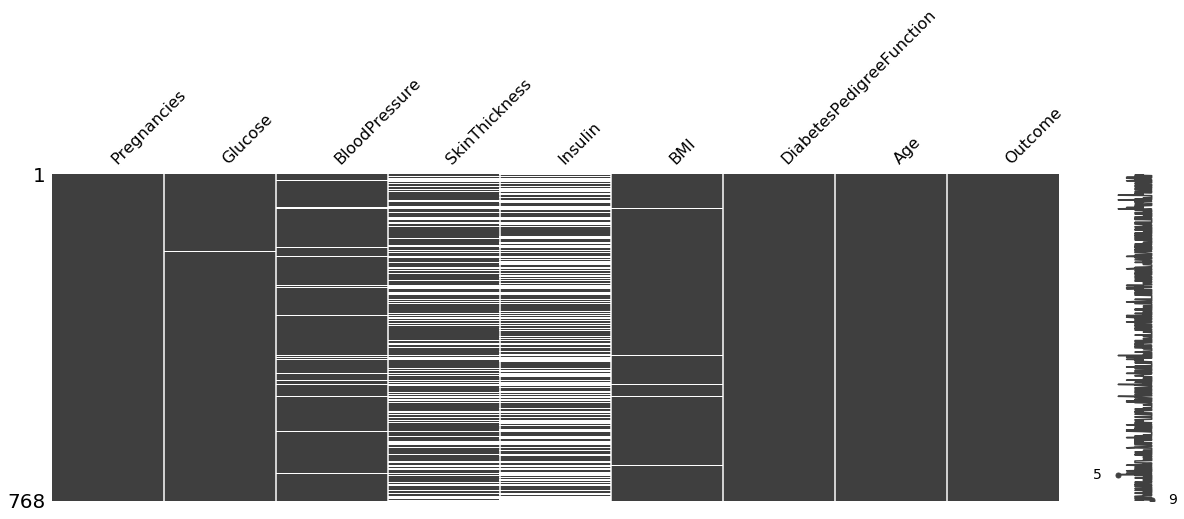

In [7]:
mno.matrix(df, figsize = (20, 6))

## Using Regression to impute missing data

In [9]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [11]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [12]:
for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

### Deterministic Regression Imputation 

In [13]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

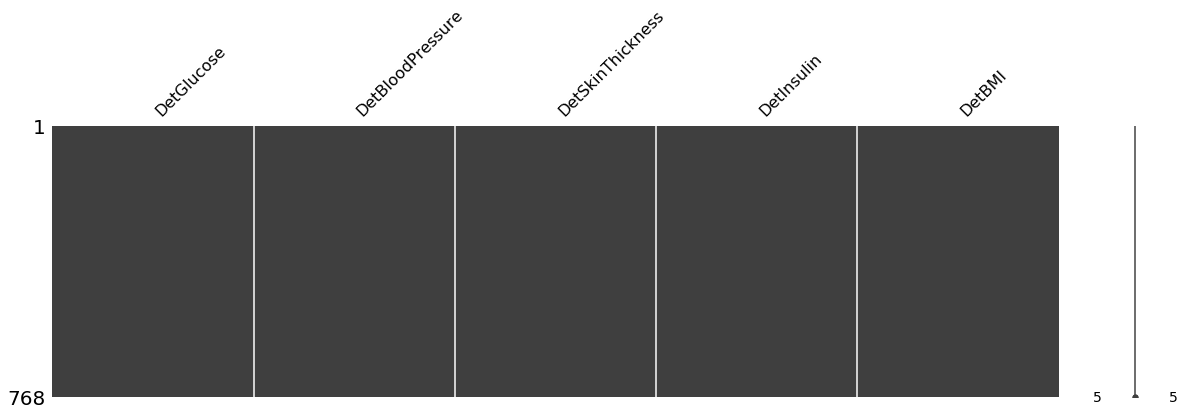

In [14]:
mno.matrix(deter_data, figsize = (20,5))

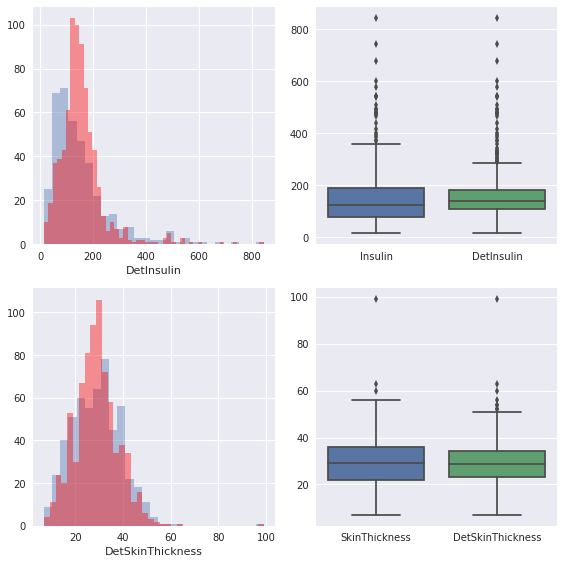

In [15]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()

In [16]:
pd.concat([df[["Insulin", "SkinThickness"]], deter_data[["DetInsulin", "DetSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.0,76.250000,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.000000,29.000000,36.000000,99.0
DetInsulin,768.0,155.182560,88.435552,14.0,109.945332,140.914671,181.266768,846.0
DetSkinThickness,768.0,29.011315,9.147896,7.0,23.000000,28.780321,34.245525,99.0


### Stochastic Regression Imputation 

In [17]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = df[feature + '_imp']
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(df[parameters])
    std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
    
    #observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = df[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                            (random_predict > 0)]


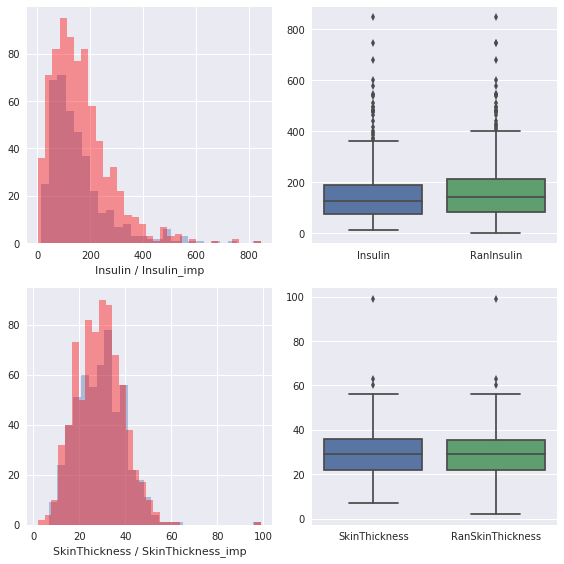

In [18]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')
    
    sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])
    
    plt.tight_layout()

In [19]:
pd.concat([df[["Insulin", "SkinThickness"]], random_data[["RanInsulin", "RanSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.000000,76.250000,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.000000,22.000000,29.000000,36.000000,99.0
RanInsulin,768.0,163.989960,111.622822,2.293967,85.000000,141.472493,212.810837,846.0
RanSkinThickness,768.0,28.882367,10.327632,1.991281,21.689989,29.000000,35.527527,99.0
